# Algoritm inteligent + real data

### 1. Descriere EDA a datelor:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
import re

In [1]:
def clean(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", "", text)
    return text

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   chief_complaint             9632 non-null   object
 1   major_surgical_procedure    6858 non-null   object
 2   history_of_present_illness  9767 non-null   object
 3   past_medical_history        9626 non-null   object
 4   family_history              9234 non-null   object
 5   physical_exam               1480 non-null   object
 6   pertinent_results           938 non-null    object
 7   cxr                         121 non-null    object
 8   us                          109 non-null    object
 9   brief_hospital_course       8321 non-null   object
 10  medications_on_admission    9027 non-null   object
 11  discharge_medications       9543 non-null   object
 12  discharge_disposition       9473 non-null   object
 13  discharge_condition         9890 non-null   obj

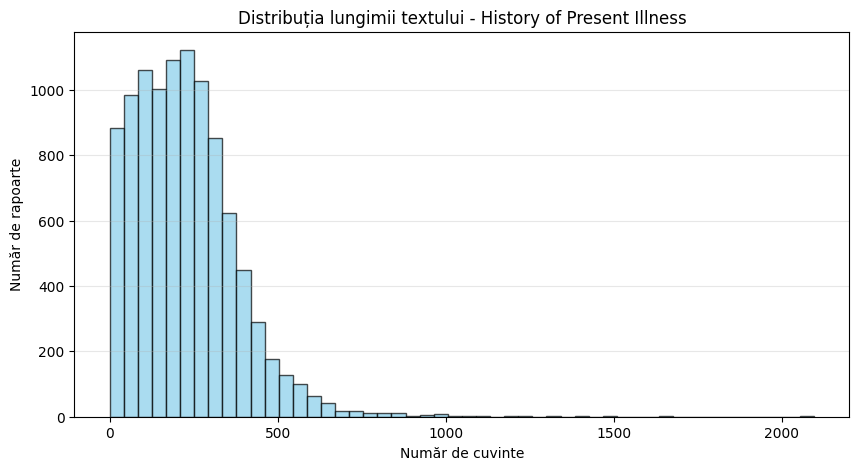

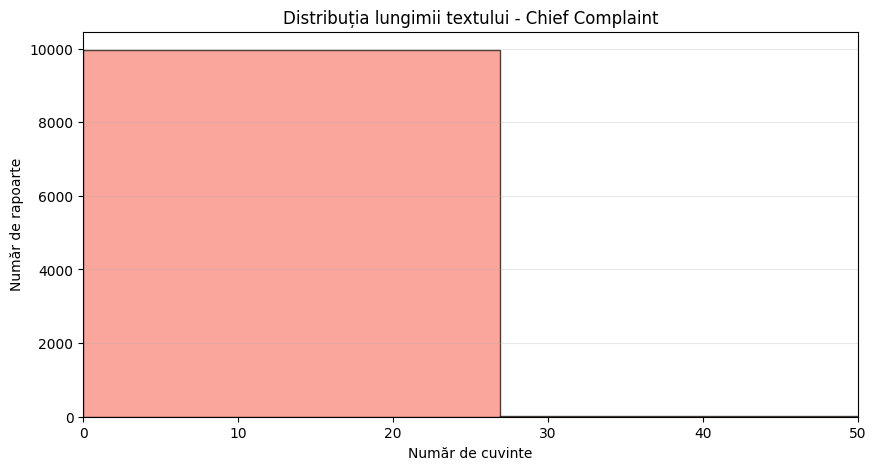

In [3]:
FILEPATH = '/Users/stiubedenis/Desktop/dataset_split/discharge-notes/'

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# incarcam 10000 de inregistrari din train pentru a analiza datele
df = pd.read_csv(FILEPATH + 'train.csv', nrows=10000)

# afisam date generale
df.info()
# afisam procentul de valori lipsa pentru fiecare coloana
print('Procentul de valori nule pentru fiecare coloana:')
print(df.isnull().mean() * 100)

# analizam distributia numarului de cuvinte pe diferite coloane
df["hpi_len"] = df["history_of_present_illness"].fillna("").astype(str).apply(lambda x: len(x.split()))
df["chief_len"] = df["chief_complaint"].fillna("").astype(str).apply(lambda x: len(x.split()))

plt.figure(figsize=(10,5))
plt.hist(df["hpi_len"], bins=50, alpha=0.7, color="skyblue", edgecolor="black")
plt.title("Distribuția lungimii textului - History of Present Illness")
plt.xlabel("Număr de cuvinte")
plt.ylabel("Număr de rapoarte")
plt.grid(axis='y', alpha=0.3)
plt.show()

plt.figure(figsize=(10,5))
plt.xlim(0, 50)
plt.hist(df["chief_len"], bins=30, alpha=0.7, color="salmon", edgecolor="black")
plt.title("Distribuția lungimii textului - Chief Complaint")
plt.xlabel("Număr de cuvinte")
plt.ylabel("Număr de rapoarte")
plt.grid(axis='y', alpha=0.3)
plt.show()


In [4]:
import pandas as pd

TRAIN_SIZE = 5000
VAL_SIZE = 500
TEST_SIZE = 500

df_train = pd.read_csv(FILEPATH + 'train.csv', nrows=TRAIN_SIZE)
df_val = pd.read_csv(FILEPATH + 'val.csv', nrows=VAL_SIZE)
df_test = pd.read_csv(FILEPATH + 'test.csv', nrows=TEST_SIZE)

### 2. Pregatirea datelor

Analizand setul de date, am constatat ca o abordare potrivita ar fi urmatoarea:
- pentru a putea face fine-tuning pe NLP (si mai ales sa antrenez stratul de clasificare), voi construi o lista de perechi (input, output);
 - **input** va fi format prin concatenarea coloanelor care contin cele mai relevante date si care ar putea fi furnizate de un pacient (*chief_complaint*, *history_of_present_illness*, *past_medical_history*). Inainte de concatenare, voi preprocesa datele din aceste campuri (**eliminarea cuvintelor de umplutura, de legatura**);
- **output-ul** va fi un label care reprezinta specialistul recomandat pentru informatiile oferite; din pacate, setul de date disponibil nu ofera aceste informatii explicit printr-un camp, astfel sunt nevoit sa caut cuvinte-cheie asociate unor simptome, afectiuni pe care sa le mapez ulterior specialistilor aferenti, construind astfel o noua coloana **recommended_specialist**; cautarea de cuvinte-cheie o voi face automatizat prin cautarea lor, folosindu-ma de un NLP simplu.

In [5]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re

# generam o multime care contine stop_words din engleza (vom dori sa le eliminam din coloanele de input)
SKLEARN_STOPWORDS = set(ENGLISH_STOP_WORDS)

# stop_words specifice domeniului medical
medical_stopwords = {
    'pt', 'patient', 'hx', 'ros', 'denies', 'admitted', 'hospital',
    'history', 'illness', 'presenting', 'states', 'reportedly', 'due',
    'mg', 'capsule', 'tablet', 'solution', 'drops', 'daily', 'tid', 'bid',
    'po', 'iv', 'unit', 'syndrome', 'vitals', 'ed', 'ra', 'o2sat', 'flow',
    'rr', 'bp', 'temp', 'pulse', 'w', 'h', 'm', 'f', 'o', 'r', 'q', 'g',
    'cc', 'cxr', 'us', 'chief', 'complaint'
}
ALL_STOPWORDS = SKLEARN_STOPWORDS.union(medical_stopwords)

INPUT_COLUMNS = ['chief_complaint', 'history_of_present_illness', 'past_medical_history']

def clean_text(text, stop_words):
    if pd.isna(text) or text is None:
        return ""

    text = str(text).lower()
    text = re.sub(r'(\s+in\s+)|(\s+at\s+)|(sometime\s+in\s+)|(\s*\d{4}\s*)|(\s*ms\.\s*,\s*)', ' ', text)
    text = re.sub(r'[^\w\s\-\/\.]', ' ', text)

    tokens = text.split()
    filtered_tokens = [token for token in tokens if token not in stop_words and len(token) > 2]

    return " ".join(filtered_tokens)

# functie pentru generarea input-ului extras din coloanele de input
def generate_processed_input(row):
    input_parts = []
    for col in INPUT_COLUMNS:
        cleaned_data = clean_text(row[col], ALL_STOPWORDS)
        if cleaned_data:
            label = col.upper().replace("_", " ")
            input_parts.append(f'{label}: {cleaned_data}')

    # vom returna string-ul, atasand separatoare intre cele trei sectiuni distincte ale input-ului
    # in Transformerele de tip BERT, [SEP] este considerat token de separare (din faza de pre-antrenament)
    return ' [SEP] '.join(input_parts)

Pentru a sti ce afectiuni sa mapez pentru fiecare specialist (pentru o construire cat mai corecta a coloanei de output), voi extrage cele mai frecvente afectiuni, medicatii din setul de antrenament folosindu-ma de informatiile din coloanele: *brief_hospital_course* si *discharge_instructions*.

In [6]:
from transformers import AutoModelForTokenClassification, pipeline, AutoTokenizer

NER_MODEL_NAME = "d4data/biomedical-ner-all"
ner_tokenizer = AutoTokenizer.from_pretrained(NER_MODEL_NAME)
ner_model = AutoModelForTokenClassification.from_pretrained(NER_MODEL_NAME)

ner_pipeline = pipeline("ner", model=ner_model, tokenizer=ner_tokenizer, aggregation_strategy="simple")

TARGET_LABELS = [
    'Disease_disorder',
    'Medication',
    'Therapeutic_procedure',
    'Sign_symptom',
    'Clinical_event' ]

OUTPUT_REF_COLUMNS = ['brief_hospital_course', 'discharge_instructions']

def extract_and_count_entities_from_ref(df, ner_pipeline, target_labels, top_n=100, reference_columns=OUTPUT_REF_COLUMNS):

    all_entities = []
    df['reference_text_combined'] = df[reference_columns].astype(str).agg(' '.join, axis=1)

    def clean_text_for_ner(text):
        text = re.sub(r'(\s+in\s+)|(\s+at\s+)|(\s*\d{4}\s*)|(\s*ms\.\s*,\s*)', ' ', str(text))
        return text.replace('nan', '').strip()

    for index, row in df.iterrows():
        text = clean_text_for_ner(row['reference_text_combined'])

        if not text:
            continue

        try:
            results = ner_pipeline(text)

            for entity in results:
                label = entity['entity_group']
                term = entity['word'].lower()

                if label in target_labels and len(term) > 2:
                    all_entities.append(term)

        except Exception as e:
            print(f"Eroare procesare rând {index}: {e}")

    return Counter(all_entities).most_common(top_n)

/Users/stiubedenis/Desktop/Facultate/An3/Semestrul1/MIRPR/projects-digitaltriagesystem/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use mps:0


In blocul de mai jos, am identificat termenii cheie asociati afectiunilor, medicamentelor:

In [7]:
top_terms = extract_and_count_entities_from_ref(df_train, ner_pipeline, TARGET_LABELS)
for term, count in top_terms:
    print(f'{term}: {count}')

pain: 6455
admitted: 2327
discharged: 2060
discharge: 1607
fever: 1329
medications: 1228
antibiotics: 1060
transferred: 858
##yp: 797
follow: 786
hyper: 777
nausea: 695
symptoms: 615
vomiting: 518
medication: 504
taken: 504
dia: 502
infection: 497
hem: 497
met: 497
bleeding: 493
presented: 487
swelling: 421
headache: 384
shortness of breath: 378
diet: 361
insulin: 358
seizure: 353
pneumonia: 352
##emia: 342
incision: 340
weakness: 340
admission: 330
con: 321
##op: 318
##x: 298
mass: 295
shower: 291
cough: 285
van: 283
##ion: 282
anti: 277
ste: 276
##bula: 275
removed: 274
dil: 273
inc: 270
##ys: 266
lasix: 263
tylenol: 259
surgery: 255
pan: 245
cop: 241
antibiotic: 237
##ema: 235
##v: 233
##rile: 232
dressing: 231
##sin: 228
catheter: 227
chemotherapy: 226
fracture: 226
cho: 224
vancomycin: 214
##ision: 213
fluids: 208
seen: 206
weight: 205
pre: 204
stent: 200
lev: 196
##pt: 190
steroids: 189
fluid: 187
##opril: 187
prop: 186
love: 186
int: 182
war: 181
weigh: 179
les: 178
void: 176
bl

In [8]:
# dictionarul de mapare specialist - lista de cuvinte-cheie asociate

SPECIALIST_MAPPING = {
    # High Priority (Specific)
    "Infectious_Disease": ["vancomycin", "antibiotic", "antibiotics", "infection", "sepsis", "chill"],
    "Cardiology": ["lasix", "heparin", "prop", "opril", "ace", "stent", "warfarin", "afib"],
    "Orthopedics_Surgery": ["surgery", "incision", "fracture", "debridement", "catheter", "removed"],
    "Oncology": ["chemotherapy", "cancer", "mass"],
    "Pulmonology": ["pneumonia", "shortness of breath", "cough"],
    "Endocrinology": ["insulin", "hyper", "weight", "diet"],
    "Gastroenterology": ["nausea", "vomiting", "diarrhea", "bleeding", "obstruction", "hem"],
    "Neurology": ["seizure", "headache", "weakness"],
    # Low Priority (General/Fallback)
    "General_Medicine": ["medications", "tylenol", "discharge", "fever", "symptoms"]
}

# eticheteaza fiecare rand cu cel mai potrivit specialist
# posibile imbunatatiri - stabilirea specialistului pe baza tuturor cuvintelor-cheie si alegerea s
def label_specialist(row, mapping_dict):
    ref_text = str(row['brief_hospital_course']) + " " + str(row['discharge_instructions'])
    ref_text = ref_text.lower()

    for label, keywords in mapping_dict.items():
        for keyword in keywords:
            if re.search(r'\b' + re.escape(keyword) + r'\b', ref_text) or re.search(r'\s' + re.escape(keyword) + r'\s', ref_text):
                return label

    return 'General_Medicine'

In [9]:
label_to_id = {label: i for i, label in enumerate(SPECIALIST_MAPPING)}
id_to_label = {i: label for i, label in enumerate(SPECIALIST_MAPPING)}

# functie pentru generarea unui dataframe ce contine perechi (input, output)
def process_data(df, label_to_id_mapping=label_to_id):
    df['input_text'] = df.apply(generate_processed_input, axis=1)
    df['specialist_label'] = df.apply(
        lambda row: label_specialist(row, SPECIALIST_MAPPING), axis=1
    )
    df['labels'] = df['specialist_label'].map(label_to_id_mapping)

    return df[['input_text', 'labels']]

In [10]:
df_train_processed = process_data(df_train)
df_val_processed = process_data(df_val)
df_test_processed = process_data(df_test)

# pentru a observa cum arata datele procesate
print(df_train_processed.head())

                                          input_text  labels
0  CHIEF COMPLAINT: infected sacral decubitus ulc...       0
1  CHIEF COMPLAINT: abdominal [SEP] HISTORY OF PR...       2
2  CHIEF COMPLAINT: neck pain s/p mva [SEP] HISTO...       4
3  CHIEF COMPLAINT: seizures [SEP] HISTORY OF PRE...       7
4  CHIEF COMPLAINT: presyncope [SEP] HISTORY OF P...       8


In [11]:
# pregatire date pentru antrenare

from datasets import Dataset, DatasetDict

df_train_processed = Dataset.from_pandas(df_train_processed)
df_val_processed = Dataset.from_pandas(df_val_processed)
df_test_processed = Dataset.from_pandas(df_test_processed)

datasets = DatasetDict({
    'train': df_train_processed,
    'val': df_val_processed,
    'test': df_test_processed
})

MODEL_NAME = "dmis-lab/biobert-base-cased-v1.2"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(
        examples["input_text"],
        truncation=True,
        padding="max_length",
        max_length=512 # Limita standard BERT
    )

tokenized_datasets = datasets.map(tokenize_function, batched=True)

print('Datele au fost tokenizate')

train_dataset = tokenized_datasets['train']
val_dataset = tokenized_datasets['val']
test_dataset = tokenized_datasets['test']

Map: 100%|██████████| 500/500 [00:00<00:00, 2275.91 examples/s]

Datele au fost tokenizate


In [12]:
from transformers import DataCollatorWithPadding
import torch
from torch.utils.data import DataLoader

tokenized_datasets.set_format("torch", columns=['input_ids', 'attention_mask', 'labels'])

BATCH_SIZE = 8
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_dataloader = DataLoader(tokenized_datasets["train"], shuffle=True, batch_size=BATCH_SIZE, collate_fn=data_collator)
eval_dataloader = DataLoader(tokenized_datasets["val"], batch_size=BATCH_SIZE, collate_fn=data_collator)
test_dataloader = DataLoader(tokenized_datasets["test"], batch_size=BATCH_SIZE, collate_fn=data_collator)

# vom incerca sa folosim gpu-ul pentru antrenare, fiind mai performant
# if torch.backends.mps.is_available():
#     DEVICE = torch.device("mps")
# else:
#     DEVICE = torch.device("cpu")
DEVICE = torch.device('cpu')
print(f"Folosind dispozitivul: {DEVICE}")

Folosind dispozitivul: cpu


### 3. Incarcare modelul

In [13]:
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification

y_train_labels = np.array(df_train_processed['labels'])

NUM_SPECIALISTS = len(np.unique(y_train_labels))
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_SPECIALISTS,
)
model.to(DEVICE)

print('BioBERT a fost incarcat cu succes!')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BioBERT a fost incarcat cu succes!


### 4. Antrenare model

In [14]:
from torch.optim import AdamW
from tqdm.auto import tqdm
from sklearn.metrics import f1_score, accuracy_score

optimizer = AdamW(model.parameters(), lr=2e-5) # ideal pentru BERT
NUM_EPOCHS = 3
best_f1_score = 0.0
best_model_path = "./best_biobert_triage_model.pth"
MAX_GRAD_NORM = 1.0

def evaluate_model(model, dataloader, device):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(batch["labels"].cpu().numpy())

    f1_macro = f1_score(true_labels, predictions, average='macro')
    accuracy = accuracy_score(true_labels, predictions)
    model.train()
    return f1_macro, accuracy

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}")

    for batch in progress_bar:
        # Mută datele pe DEVICE (MPS)
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        batch['labels'] = batch['labels'].to(torch.long)

        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({"Avg Loss": total_loss / (progress_bar.n + 1)})

    # Evaluare pe setul de VALIDARE (la sfârșitul epocii)
    f1_val, acc_val = evaluate_model(model, eval_dataloader, DEVICE)
    print(f"\n--- Epoch {epoch + 1} Results ---")
    print(f"Validation F1 Macro: {f1_val:.4f} | Validation Accuracy: {acc_val:.4f}")

    # Salvează cel mai bun model bazat pe F1-Score
    if f1_val > best_f1_score:
        best_f1_score = f1_val
        torch.save(model.state_dict(), best_model_path)
        print(f"Model salvat: F1 îmbunătățit la {f1_val:.4f}")

Training Epoch 1: 100%|██████████| 625/625 [51:54<00:00,  4.98s/it, Avg Loss=1.53] 



--- Epoch 1 Results ---
Validation F1 Macro: 0.1521 | Validation Accuracy: 0.5440
Model salvat: F1 îmbunătățit la 0.1521


Training Epoch 2:  30%|███       | 188/625 [17:55<41:39,  5.72s/it, Avg Loss=1.29] 


KeyboardInterrupt: 

### 5. Testare performanta

In [15]:
# Asigură-te că aceste variabile sunt definite:
# DEVICE (e.g., torch.device('cpu'))
# MODEL_NAME ("dmis-lab/biobert-base-cased-v1.2")
# NUM_SPECIALISTS (9)
best_model_path = "./best_biobert_triage_model.pth"

# Creează o nouă instanță a modelului (aceeași arhitectură)
final_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_SPECIALISTS,
)

# Încarcă ponderile salvate din fișierul .pth
final_model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))

# Mută modelul pe dispozitivul dorit
final_model.to(DEVICE)

print(f"Modelul final a fost încărcat din {best_model_path}.")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modelul final a fost încărcat din ./best_biobert_triage_model.pth.


In [16]:
def evaluate_model(model, dataloader, device):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}

            if 'labels' in batch:
                batch['labels'] = batch['labels'].to(torch.long)

            # Inferență
            outputs = model(**batch)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(batch["labels"].cpu().numpy())

    # Calculează metricile
    f1_macro = f1_score(true_labels, predictions, average='macro')
    f1_weighted = f1_score(true_labels, predictions, average='weighted')
    accuracy = accuracy_score(true_labels, predictions)

    # Modelul rămâne în modul eval după apel
    return f1_macro, f1_weighted, accuracy, true_labels, predictions

In [17]:
print("\n--- Evaluare pe Setul de Testare ---")
f1_macro_test, f1_weighted_test, acc_test, true_labels, predictions = evaluate_model(
    final_model,
    test_dataloader,
    DEVICE
)

print(f"Acuratețe Test: {acc_test:.4f}")
print(f"F1-Score Macro Test: {f1_macro_test:.4f}")
print(f"F1-Score Weighted Test: {f1_weighted_test:.4f}")

# Re-pune modelul în modul de antrenare dacă intenționezi să mai faci fine-tuning
final_model.train()


--- Evaluare pe Setul de Testare ---
Acuratețe Test: 0.5500
F1-Score Macro Test: 0.1687
F1-Score Weighted Test: 0.4407


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e


--- Raport de Clasificare Detaliat ---
                     precision    recall  f1-score   support

 Infectious_Disease       0.54      0.96      0.69       247
         Cardiology       0.64      0.35      0.45        85
Orthopedics_Surgery       0.00      0.00      0.00        61
           Oncology       0.00      0.00      0.00        18
        Pulmonology       0.00      0.00      0.00        10
      Endocrinology       0.00      0.00      0.00        22
   Gastroenterology       0.00      0.00      0.00        17
          Neurology       0.00      0.00      0.00        11
   General_Medicine       0.57      0.28      0.37        29

           accuracy                           0.55       500
          macro avg       0.19      0.18      0.17       500
       weighted avg       0.41      0.55      0.44       500


--- Matrice de Confuzie ---
[[237   8   1   0   0   0   0   0   1]
 [ 55  30   0   0   0   0   0   0   0]
 [ 57   3   0   0   0   0   0   0   1]
 [ 17   1   0   0 

/Users/stiubedenis/Desktop/Facultate/An3/Semestrul1/MIRPR/projects-digitaltriagesystem/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/stiubedenis/Desktop/Facultate/An3/Semestrul1/MIRPR/projects-digitaltriagesystem/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/stiubedenis/Desktop/Facultate/An3/Semestrul1/MIRPR/projects-digitaltriagesystem/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precisi

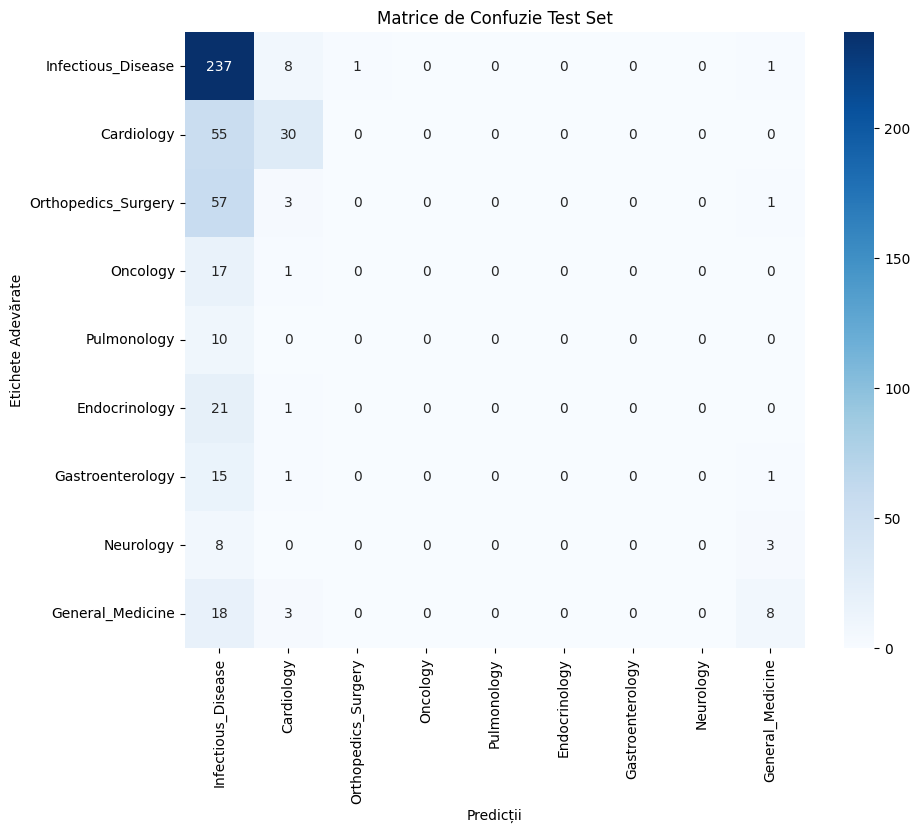

In [19]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = list(id_to_label.values())

print("\n--- Raport de Clasificare Detaliat ---")
print(classification_report(true_labels, predictions, target_names=target_names))

print("\n--- Matrice de Confuzie ---")
conf_matrix = confusion_matrix(true_labels, predictions)
print(conf_matrix)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names
)
plt.xlabel('Predicții')
plt.ylabel('Etichete Adevărate')
plt.title('Matrice de Confuzie Test Set')
plt.show()